Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
from datetime import datetime as dt
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
data_root = '../../input/notMNIST/' # Change me to store data elsewhere
pickle_file = data_root + 'notMNIST.pickle'

label_dic = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J'}

print('pickle file location: %s' % pickle_file)

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset_rw = save['train_dataset']
    train_labels_rw = save['train_labels']
    valid_dataset_rw = save['valid_dataset']
    valid_labels_rw = save['valid_labels']
    test_dataset_rw = save['test_dataset']
    test_labels_rw = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset_rw.shape, train_labels_rw.shape)
    print('Validation set', valid_dataset_rw.shape, valid_labels_rw.shape)
    print('Test set', test_dataset_rw.shape, test_labels_rw.shape)

pickle file location: ../../input/notMNIST/notMNIST.pickle
Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


1, 10
H H A B B A 

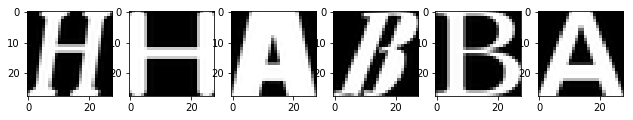

In [3]:
import math

img_idx_list = list(range(2090,2096))
img_idx_len = len(img_idx_list)

col_num = 10
row_num = math.ceil(img_idx_len / col_num)

print("%d, %d" % (row_num, col_num))

plt.figure(figsize=(18, 2 * row_num))
for i, idx in enumerate(img_idx_list):
    print(label_dic[train_labels_rw[idx]], end=' ')
    if i % col_num + 1 == col_num:
        print()
    plt.subplot(row_num, col_num, i+1)
    plt.imshow(train_dataset_rw[idx], cmap='gray')


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset_rw, train_labels_rw)
valid_dataset, valid_labels = reformat(valid_dataset_rw, valid_labels_rw)
test_dataset, test_labels = reformat(test_dataset_rw, test_labels_rw)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [5]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def show_result(predictions, labels):
    print([label_dic[key] for key in np.argmax(predictions, 1)])
    print([label_dic[key] for key in np.argmax(labels, 1)])


In [9]:
# Define a fully connected layer
def fc_layer(input_x, channels_in, channels_out, act=None, layer_name='Full_Connection_Layer', logs=None):
    with tf.name_scope(layer_name):
        # It is not a good idea to set initial value as zero
        # It will cause problem during the learning activity
        # w = tf.Variable(tf.zeros([channels_in, channels_out]))

        # These are the parameters that we are going to be training. The weight
        # matrix will be initialized using random values following a (truncated)
        # normal distribution.
        
        with tf.variable_scope(layer_name):
            # weights = tf.Variable(tf.truncated_normal([channels_in, channels_out], seed=1), name='W')
            weights = tf.get_variable(name='Weights', shape=[channels_in, channels_out], \
                                      initializer=tf.truncated_normal_initializer(seed=1))
            # The biases get initialized to zero.
            # biases = tf.Variable(tf.zeros([channels_out]), name='B')
            biases = tf.get_variable(name='Biases', shape=[channels_out], \
                                    initializer=tf.zeros_initializer())
            if logs=='Y':
                tf.summary.histogram("Weights", weights)
                tf.summary.histogram("Biases", biases)
        
        fc_conn = tf.matmul(input_x, weights)
        
        if act=='relu':
            act = tf.nn.relu(fc_conn + biases)
        else:
            act = fc_conn + biases

        # tf.summary.histogram("fc_conn", fc_conn)

        return act


# Define a Convolutional layer
def conv_layer(input_x, channels_in, channels_out, layer_name='Convolutional_Layer'):
    with tf.name_scope(layer_name):
        with tf.variable_scope(layer_name):
            weights = tf.Variable(tf.zeros([5, 5, channels_in, channels_out]), name='Weights')
            biases = tf.Variable(tf.zeros(channels_out), name='Biases')
        conv_conn = tf.nn.conv2d(input_x, weights, strides=[1, 1, 1, 1], padding='SAME')
        act = tf.nn.relu(conv_conn + biases)

        tf.summary.histogram("Weights", weights)
        tf.summary.histogram("Biases", biases)
        # tf.summary.histogram("conv_conn", conv_conn)

        return act
    

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [40]:
# build the network graph

hidden_Layer_nod_size = 1028

graph_1 = tf.Graph()
with graph_1.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    with tf.name_scope('Input_X'):
        tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size * image_size), name='Train_X')
        # tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size), name='Train_X')
        # tf_valid_dataset = tf.constant(valid_dataset, name='Valid_X')
        # tf_test_dataset = tf.constant(test_dataset, name='Test_X')

    with tf.name_scope('Labels_y'):
        # tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels), name='T_y')
        tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels), name='T_y')
        
    with tf.name_scope('Beta_L2_regu'):
        tf_beta_l2_regu = tf.placeholder(tf.float32, name='Beta_L2_regu')

    with tf.name_scope('Data_reshape_for_image'):
        # image for display purpose
        tf_train_ds_image = tf.reshape(tf_train_dataset, [-1, 28, 28, 1])
        # tensorboard logging
        tf.summary.image('input', tf_train_ds_image, 3)

    # Create the network

    # x(784) - fc : relu - y(10)
    # Minibatch accuracy: 79.7% : Validation accuracy: 81.4% : Test accuracy: 88.5%
    full_conn_1 = fc_layer(tf_train_dataset, image_size * image_size, num_labels, act='relu', layer_name='fc_conn_1')
    logits = full_conn_1
    
    # x(784) - fc : relu - h(1024) - fc - y(10)
    # Minibatch loss at step 3000: 15.423422
    # Minibatch accuracy: 88.3%
    # Validation accuracy: 86.1%
    # Test accuracy: 92.9%

    # full_conn_1 = fc_layer(tf_train_dataset, image_size * image_size, hidden_Layer_nod_size, act='relu', layer_name='fc_conn_1')
    # logits = fc_layer(full_conn_1, hidden_Layer_nod_size, num_labels, layer_name='fc_conn_2')
    
    # x(784) - fc - h(1024), dropout() - fc - y(10)
    # full_conn_1 = fc_layer(tf_train_dataset, image_size * image_size, hidden_Layer_nod_size, layer_name='fc_conn_1')
    # dropout_act = tf.nn.dropout(full_conn_1, keep_prob=tf_keep_prob, name='Dropout_Act')
    # logits = fc_layer(dropout_act, hidden_Layer_nod_size, num_labels, layer_name='fc_conn_2')

    with tf.variable_scope('fc_conn_1', reuse=True):
            fc_conn_1_w = tf.get_variable("Weights", [image_size * image_size, num_labels])
    
    # with tf.variable_scope('fc_conn_2', reuse=True):
    #        fc_conn_2_w = tf.get_variable("Weights", [hidden_Layer_nod_size, num_labels])
            
    with tf.name_scope('loss_function'):
        l2_loss = tf.nn.l2_loss(fc_conn_1_w, name='l2_loss_w1') # + tf.nn.l2_loss(fc_conn_2_w, name='l2_loss_w2')
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,
                                                                         logits=logits), name='cross_entropy') \
            + tf_beta_l2_regu * l2_loss
        
        tf.summary.scalar('beta_l2_regu', tf_beta_l2_regu)
        tf.summary.scalar('cross_entropy', loss)
        tf.summary.scalar('l2_loss', l2_loss)

    # Optimizer.
    with tf.name_scope('Optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Accuracy
    with tf.name_scope('Accuracy'):
        prediction = logits
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(tf_train_labels, 1))
        accuracy_res = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('Accuracy_Result', accuracy_res)



In [41]:
# Run the model

batch_size = 128
num_steps = 3001
beta_l2_regu = 0.001

with tf.Session(graph=graph_1) as session:

    # Initialize all the variables
    # session.run(tf.global_variables_initializer())
    tf.global_variables_initializer().run()
    print("Initialized")

    # Make the tensorboard log writer
    session_log_dir = "logs/3_1/" + dt.today().strftime('%Y%m%d-%H%M%S')
    writer = tf.summary.FileWriter(session_log_dir)
    print("Logging Directory : %s" % session_log_dir)
    
    writer.add_graph(session.graph)

    # Merge all the tf summary
    merged_summary = tf.summary.merge_all()

    # Data Set
    # Minibatch will be built in loop
    valid_feed_dict = {tf_train_dataset: valid_dataset, tf_train_labels: valid_labels, tf_beta_l2_regu: beta_l2_regu}
    test_feed_dict = {tf_train_dataset: test_dataset, tf_train_labels: test_labels, tf_beta_l2_regu: beta_l2_regu}

    for step in range(num_steps):

        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        train_feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta_l2_regu: beta_l2_regu}

        if step % 5 == 0:
            s = session.run(merged_summary, feed_dict=train_feed_dict)
            writer.add_summary(s, step)

        _, l, train_prediction = session.run([optimizer, loss, prediction], feed_dict=train_feed_dict)

        if step % 500 == 0:
            # Predictions for the validation, and test data.

            valid_prediction = session.run(logits, feed_dict=valid_feed_dict)
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(train_prediction, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction, valid_labels))

    test_prediction = session.run(logits, feed_dict=test_feed_dict)
    print("Test accuracy: %.1f%%" % accuracy(test_prediction, test_labels))
    writer.close()
    



Initialized
Logging Directory : logs/3_1/20180926-213204
Minibatch loss at step 0: 16.034826
Minibatch accuracy: 7.0%
Validation accuracy: 12.1%
Minibatch loss at step 500: 2.423964
Minibatch accuracy: 76.6%
Validation accuracy: 73.7%
Minibatch loss at step 1000: 1.935727
Minibatch accuracy: 75.8%
Validation accuracy: 77.7%
Minibatch loss at step 1500: 1.110502
Minibatch accuracy: 83.6%
Validation accuracy: 80.0%
Minibatch loss at step 2000: 0.823556
Minibatch accuracy: 86.7%
Validation accuracy: 81.3%
Minibatch loss at step 2500: 0.777571
Minibatch accuracy: 82.0%
Validation accuracy: 81.9%
Minibatch loss at step 3000: 0.742987
Minibatch accuracy: 83.6%
Validation accuracy: 82.7%
Test accuracy: 89.5%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

**One training data will cause 100% result always**.

More then one training dataset won't always cause high accuracy training result. It depends on the train dataset quality. `With notise data, the training result could be low as well. `

1028 hidden layer nodes classify the input (include the noise) more specific. So the 100% is achieved.

---

In [42]:
# build the network graph

hidden_Layer_nod_size = 10

graph_2 = tf.Graph()
with graph_2.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    with tf.name_scope('Input_X'):
        tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size * image_size), name='Train_X')
        # tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size), name='Train_X')
        # tf_valid_dataset = tf.constant(valid_dataset, name='Valid_X')
        # tf_test_dataset = tf.constant(test_dataset, name='Test_X')

    with tf.name_scope('Labels_y'):
        # tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels), name='T_y')
        tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels), name='T_y')
        
    with tf.name_scope('Beta_L2_regu'):
        tf_beta_l2_regu = tf.placeholder(tf.float32, name='Beta_L2_regu')

    with tf.name_scope('Data_reshape_for_image'):
        # image for display purpose
        tf_train_ds_image = tf.reshape(tf_train_dataset, [-1, 28, 28, 1])
        # tensorboard logging
        tf.summary.image('input', tf_train_ds_image, 3)

    # Create the network

    # x(784) - fc : relu - y(10)
    # Minibatch accuracy: 79.7% : Validation accuracy: 81.4% : Test accuracy: 88.5%
    # full_conn_1 = fc_layer(tf_train_dataset, image_size * image_size, num_labels, act='relu', layer_name='fc_conn_1')
    # logits = full_conn_1
    
    # x(784) - fc : relu - h(1024) - fc - y(10)
    # Minibatch loss at step 3000: 15.423422
    # Minibatch accuracy: 88.3%
    # Validation accuracy: 86.1%
    # Test accuracy: 92.9%

    full_conn_1 = fc_layer(tf_train_dataset, image_size * image_size, hidden_Layer_nod_size, layer_name='fc_conn_1')
    logits = fc_layer(full_conn_1, hidden_Layer_nod_size, num_labels, layer_name='fc_conn_2')
    
    # x(784) - fc - h(1024), dropout() - fc - y(10)
    # full_conn_1 = fc_layer(tf_train_dataset, image_size * image_size, hidden_Layer_nod_size, layer_name='fc_conn_1')
    # dropout_act = tf.nn.dropout(full_conn_1, keep_prob=tf_keep_prob, name='Dropout_Act')
    # logits = fc_layer(dropout_act, hidden_Layer_nod_size, num_labels, layer_name='fc_conn_2')

    with tf.variable_scope('fc_conn_1', reuse=True):
            fc_conn_1_w = tf.get_variable("Weights", [image_size * image_size, hidden_Layer_nod_size])
    
    with tf.variable_scope('fc_conn_2', reuse=True):
            fc_conn_2_w = tf.get_variable("Weights", [hidden_Layer_nod_size, num_labels])
            
    with tf.name_scope('loss_function'):
        l2_loss = tf.nn.l2_loss(fc_conn_1_w, name='l2_loss_w1') + tf.nn.l2_loss(fc_conn_2_w, name='l2_loss_w2')
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,
                                                                         logits=logits), name='cross_entropy') \
            + tf_beta_l2_regu * l2_loss
        
        tf.summary.scalar('beta_l2_regu', tf_beta_l2_regu)
        tf.summary.scalar('cross_entropy', loss)
        tf.summary.scalar('l2_loss', l2_loss)

    # Optimizer.
    with tf.name_scope('Optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Accuracy
    with tf.name_scope('Accuracy'):
        prediction = logits
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(tf_train_labels, 1))
        accuracy_res = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('Accuracy_Result', accuracy_res)



In [43]:
# Run the model

batch_size = 128
num_steps = 3000
beta_l2_regu = 0.01

with tf.Session(graph=graph_2) as session:

    # Initialize all the variables
    # session.run(tf.global_variables_initializer())
    tf.global_variables_initializer().run()
    print("Initialized")

    # Make the tensorboard log writer
    session_log_dir = "logs/3_2/" + dt.today().strftime('%Y%m%d%H%M%S')
    writer = tf.summary.FileWriter(session_log_dir)
    print("Logging Directory : %s" % session_log_dir)
    
    writer.add_graph(session.graph)

    # Merge all the tf summary
    merged_summary = tf.summary.merge_all()

    # Data Set
    # Minibatch will be built in loop
    valid_feed_dict = {tf_train_dataset: valid_dataset, tf_train_labels: valid_labels, tf_beta_l2_regu: beta_l2_regu}
    test_feed_dict = {tf_train_dataset: test_dataset, tf_train_labels: test_labels, tf_beta_l2_regu: beta_l2_regu}

    for step in range(num_steps):

        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        # offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = batch_size * (step % 5)

        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        # print("batch_data shape :", batch_data.shape)
        # print("batch_labels shape : ", batch_labels.shape)

        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        train_feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta_l2_regu: beta_l2_regu}
        
        if step % 5 == 0:
            s = session.run(merged_summary, feed_dict=train_feed_dict)
            writer.add_summary(s, step)

        _, l, train_prediction = session.run([optimizer, loss, prediction], feed_dict=train_feed_dict)

        if step % 500 == 0:
            # Predictions for the validation, and test data.
            valid_prediction = session.run(logits, feed_dict=valid_feed_dict)
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(train_prediction, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction, valid_labels))

    test_prediction = session.run(logits, feed_dict=test_feed_dict)
    print("Test accuracy: %.1f%%" % accuracy(test_prediction, test_labels))
    writer.close()
    


Initialized
Logging Directory : logs/3_2/20180926213307
Minibatch loss at step 0: 81.505920
Minibatch accuracy: 7.8%
Validation accuracy: 23.3%
Minibatch loss at step 500: 0.580571
Minibatch accuracy: 98.4%
Validation accuracy: 76.1%
Minibatch loss at step 1000: 0.388106
Minibatch accuracy: 99.2%
Validation accuracy: 77.0%
Minibatch loss at step 1500: 0.386360
Minibatch accuracy: 99.2%
Validation accuracy: 77.1%
Minibatch loss at step 2000: 0.386276
Minibatch accuracy: 99.2%
Validation accuracy: 77.1%
Minibatch loss at step 2500: 0.386258
Minibatch accuracy: 99.2%
Validation accuracy: 77.1%
Test accuracy: 84.7%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [19]:
# build the network graph

hidden_Layer_nod_size = 1000

graph_3 = tf.Graph()
with graph_3.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    with tf.name_scope('Input_X'):
        tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size * image_size), name='Train_X')
        # tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size), name='Train_X')
        # tf_valid_dataset = tf.constant(valid_dataset, name='Valid_X')
        # tf_test_dataset = tf.constant(test_dataset, name='Test_X')

    with tf.name_scope('Labels_y'):
        # tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels), name='T_y')
        tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels), name='T_y')
        
    tf_keep_prob = tf.placeholder(tf.float32, name='keep_prob') # dropout probability
    tf_beta_l2_regu = tf.placeholder(tf.float32, name='Beta_L2_regu')

    with tf.name_scope('Data_reshape_for_image'):
        # image for display purpose
        tf_train_ds_image = tf.reshape(tf_train_dataset, [-1, 28, 28, 1])
        # tensorboard logging
        tf.summary.image('input', tf_train_ds_image, 3)

    # Create the network

    # x(784) - fc : relu - y(10)
    # Minibatch accuracy: 79.7% : Validation accuracy: 81.4% : Test accuracy: 88.5%
    # full_conn_1 = fc_layer(tf_train_dataset, image_size * image_size, num_labels, act='relu', layer_name='fc_conn_1')
    # logits = full_conn_1
    
    # x(784) - fc : relu - h(1024) - fc - y(10)
    # Minibatch loss at step 3000: 15.423422
    # Minibatch accuracy: 88.3%
    # Validation accuracy: 86.1%
    # Test accuracy: 92.9%

    # full_conn_1 = fc_layer(tf_train_dataset, image_size * image_size, hidden_Layer_nod_size, act='relu', layer_name='fc_conn_1')
    # logits = fc_layer(full_conn_1, hidden_Layer_nod_size, num_labels, layer_name='fc_conn_2')
    
    # x(784) - fc - h(1024), dropout() - fc - y(10)
    full_conn_1 = fc_layer(tf_train_dataset, image_size * image_size, hidden_Layer_nod_size, layer_name='fc_conn_1')
    dropout_act = tf.nn.dropout(full_conn_1, keep_prob=tf_keep_prob, name='Dropout_Act')
    logits = fc_layer(dropout_act, hidden_Layer_nod_size, num_labels, layer_name='fc_conn_2')

    with tf.variable_scope('fc_conn_1', reuse=True):
            fc_conn_1_w = tf.get_variable("Weights", [image_size * image_size, hidden_Layer_nod_size])
    
    with tf.variable_scope('fc_conn_2', reuse=True):
            fc_conn_2_w = tf.get_variable("Weights", [hidden_Layer_nod_size, num_labels])
            
    with tf.name_scope('loss_function'):
        l2_loss = tf.nn.l2_loss(fc_conn_1_w, name='l2_loss_w1') + tf.nn.l2_loss(fc_conn_2_w, name='l2_loss_w2')
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,
                                                                         logits=logits), name='cross_entropy') \
            + tf_beta_l2_regu * l2_loss
        
        tf.summary.scalar('beta_l2_regu', tf_beta_l2_regu)
        tf.summary.scalar('cross_entropy', loss)
        tf.summary.scalar('l2_loss', l2_loss)

    # Optimizer.
    with tf.name_scope('Optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Accuracy
    with tf.name_scope('Accuracy'):
        prediction = logits
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(tf_train_labels, 1))
        accuracy_res = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('Accuracy_Result', accuracy_res)



In [20]:
# Run the model

batch_size = 128
keep_prob = 0.8
beta_l2_regu = 0.01
num_steps = 3001

with tf.Session(graph=graph_3) as session:

    # Initialize all the variables
    # session.run(tf.global_variables_initializer())
    tf.global_variables_initializer().run()
    print("Initialized")

    # Make the tensorboard log writer
    session_log_dir = "logs/3_3/" + dt.today().strftime('%Y%m%d%H%M%S')
    writer = tf.summary.FileWriter(session_log_dir)
    print("Logging Directory : %s" % session_log_dir)
    
    writer.add_graph(session.graph)

    # Merge all the tf summary
    merged_summary = tf.summary.merge_all()

    # Data Set
    # Minibatch will be built in loop
    valid_feed_dict = {tf_train_dataset: valid_dataset, 
                       tf_train_labels: valid_labels, 
                       tf_keep_prob: 1,
                       tf_beta_l2_regu: beta_l2_regu
                      }
    test_feed_dict = {tf_train_dataset: test_dataset, 
                      tf_train_labels: test_labels, 
                      tf_keep_prob: 1,
                      tf_beta_l2_regu: beta_l2_regu
                     }

    for step in range(num_steps):
        
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        # offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = batch_size * (step % 5)

        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        # print("batch_data shape :", batch_data.shape)
        # print("batch_labels shape : ", batch_labels.shape)
    
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.

        train_feed_dict = {tf_train_dataset: batch_data, 
                           tf_train_labels: batch_labels, 
                           tf_keep_prob: keep_prob,
                           tf_beta_l2_regu: beta_l2_regu
                          }
        
        if step % 5 == 0:
            s = session.run(merged_summary, feed_dict=train_feed_dict)
            writer.add_summary(s, step)

        _, l, train_prediction = session.run([optimizer, loss, prediction], feed_dict=train_feed_dict)

        if step % 500 == 0:
            # Predictions for the validation, and test data.

            valid_prediction = session.run(logits, feed_dict=valid_feed_dict)
            print("Minibatch loss at step %d: %f" % (step, l))
            # print(show_result(train_prediction, batch_labels))
            print("Minibatch accuracy: %.1f%%" % accuracy(train_prediction, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction, valid_labels))

    test_prediction = session.run(logits, feed_dict=test_feed_dict)
    print("Test accuracy: %.1f%%" % accuracy(test_prediction, test_labels))
    writer.close()
    session.close()


Initialized
Logging Directory : logs/3_3/20180929175944
Minibatch loss at step 0: 3605.950928
Minibatch accuracy: 12.5%
Validation accuracy: 33.6%
Minibatch loss at step 500: 20.558727
Minibatch accuracy: 100.0%
Validation accuracy: 75.4%
Minibatch loss at step 1000: 0.540625
Minibatch accuracy: 99.2%
Validation accuracy: 76.6%
Minibatch loss at step 1500: 0.406980
Minibatch accuracy: 97.7%
Validation accuracy: 76.5%
Minibatch loss at step 2000: 0.390388
Minibatch accuracy: 99.2%
Validation accuracy: 76.9%
Minibatch loss at step 2500: 0.401039
Minibatch accuracy: 99.2%
Validation accuracy: 76.9%
Minibatch loss at step 3000: 0.393565
Minibatch accuracy: 98.4%
Validation accuracy: 77.0%
Test accuracy: 84.4%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [1]:
# build the network graph

hidden_layer_1_node = 1028
hidden_layer_2_node = 100

graph_4 = tf.Graph()
with graph_4.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    with tf.name_scope('Input_X'):
        tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size * image_size), name='Train_X')
        # tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size), name='Train_X')
        # tf_valid_dataset = tf.constant(valid_dataset, name='Valid_X')
        # tf_test_dataset = tf.constant(test_dataset, name='Test_X')

    with tf.name_scope('Labels_y'):
        # tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels), name='T_y')
        tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels), name='T_y')
        
    tf_keep_prob = tf.placeholder(tf.float32, name='keep_prob') # dropout probability
    tf_beta_l2_regu = tf.placeholder(tf.float32, name='Beta_L2_regu')

    with tf.name_scope('Data_reshape_for_image'):
        # image for display purpose
        tf_train_ds_image = tf.reshape(tf_train_dataset, [-1, 28, 28, 1])
        # tensorboard logging
        tf.summary.image('input', tf_train_ds_image, 3)

    # Create the network

    # x(784) - fc : relu - y(10)
    # Minibatch accuracy: 79.7% : Validation accuracy: 81.4% : Test accuracy: 88.5%
    # full_conn_1 = fc_layer(tf_train_dataset, image_size * image_size, num_labels, act='relu', layer_name='fc_conn_1')
    # logits = full_conn_1
    
    # x(784) - fc : relu - h(1024) - fc - y(10)
    # Minibatch loss at step 3000: 15.423422
    # Minibatch accuracy: 88.3%
    # Validation accuracy: 86.1%
    # Test accuracy: 92.9%

    # full_conn_1 = fc_layer(tf_train_dataset, image_size * image_size, hidden_Layer_nod_size, act='relu', layer_name='fc_conn_1')
    # logits = fc_layer(full_conn_1, hidden_Layer_nod_size, num_labels, layer_name='fc_conn_2')
    
    # x(784) - fc - h(1028), dropout() - fc - y(10)

    full_conn_1 = fc_layer(tf_train_dataset, image_size * image_size, hidden_layer_1_node, 
                           layer_name='fc_conn_1', act='relu', logs='Y')
#     dropout_act_1 = tf.nn.dropout(full_conn_1, keep_prob=tf_keep_prob, name='Dropout_Act_1')
#     full_conn_2 = fc_layer(dropout_act_1, hidden_layer_1_node, hidden_layer_2_node, layer_name='fc_conn_2', 
#                            act='relu', logs='Y')
#     dropout_act_2 = tf.nn.dropout(full_conn_2, keep_prob=tf_keep_prob, name='Dropout_Act_2')
#     logits = fc_layer(dropout_act_2, hidden_layer_2_node, num_labels, layer_name='fc_conn_3')

    dropout_act = tf.nn.dropout(full_conn_1, keep_prob=tf_keep_prob, name='Dropout_Act')
    logits = fc_layer(full_conn_1, hidden_layer_1_node, num_labels, 
                      layer_name='fc_conn_2', logs='Y')    
    
#     with tf.variable_scope('fc_conn_1', reuse=True):
#         fc_conn_1_w = tf.get_variable("Weights", [image_size * image_size, hidden_layer_1_node])
    
#     with tf.variable_scope('fc_conn_2', reuse=True):
#         fc_conn_2_w = tf.get_variable("Weights", [hidden_layer_1_node, hidden_layer_2_node])
            
#     with tf.variable_scope('fc_conn_3', reuse=True):
#         fc_conn_3_w = tf.get_variable("Weights", [hidden_layer_2_node, num_labels])
            
#     with tf.name_scope('loss_function'):
#         l2_loss = tf.nn.l2_loss(fc_conn_1_w, name='l2_loss_w1') \
#                 + tf.nn.l2_loss(fc_conn_2_w, name='l2_loss_w2') \
#                 + tf.nn.l2_loss(fc_conn_3_w, name='l2_loss_w3')
                
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,
                                                                         logits=logits), name='cross_entropy')
#              + tf_beta_l2_regu * l2_loss
        
    tf.summary.scalar('beta_l2_regu', tf_beta_l2_regu)
    tf.summary.scalar('loss_cross_entropy', loss)
#     tf.summary.scalar('l2_loss', l2_loss)

    # Optimizer.
    with tf.name_scope('Optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Accuracy
    with tf.name_scope('Accuracy'):
        prediction = logits
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(tf_train_labels, 1))
        accuracy_res = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('Accuracy_Result', accuracy_res)



NameError: name 'tf' is not defined

In [38]:
# Run the model

batch_size = 128
keep_prob = 1
beta_l2_regu = 0.01
num_steps = 3001

with tf.Session(graph=graph_4) as session:

    # Initialize all the variables
    # session.run(tf.global_variables_initializer())
    tf.global_variables_initializer().run()
    print("Initialized")

    # Make the tensorboard log writer
    session_log_dir = "logs/3_4/" + dt.today().strftime('%Y%m%d_%H%M%S')
    writer = tf.summary.FileWriter(session_log_dir)
    print("Logging Directory : %s" % session_log_dir)
    
    writer.add_graph(session.graph)

    # Merge all the tf summary
    merged_summary = tf.summary.merge_all()

    # Data Set
    # Minibatch will be built in loop
    valid_feed_dict = {tf_train_dataset: valid_dataset, 
                       tf_train_labels: valid_labels, 
                       tf_keep_prob: 1,
                       tf_beta_l2_regu: beta_l2_regu
                      }
    test_feed_dict = {tf_train_dataset: test_dataset, 
                      tf_train_labels: test_labels, 
                      tf_keep_prob: 1,
                      tf_beta_l2_regu: beta_l2_regu
                     }

    for step in range(num_steps):
        
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # focus on the 5 data batch to get overfitting case. 
        # offset = batch_size * (step % 5)

        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        # print("batch_data shape :", batch_data.shape)
        # print("batch_labels shape : ", batch_labels.shape)
    
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.

        train_feed_dict = {tf_train_dataset: batch_data, 
                           tf_train_labels: batch_labels, 
                           tf_keep_prob: keep_prob,
                           tf_beta_l2_regu: beta_l2_regu
                          }
        
        if step % 5 == 0:
            s = session.run(merged_summary, feed_dict=train_feed_dict)
            writer.add_summary(s, step)

        _, l, train_prediction = session.run([optimizer, loss, prediction], feed_dict=train_feed_dict)

        if step % 500 == 0:
            # Predictions for the validation, and test data.

            valid_prediction = session.run(logits, feed_dict=valid_feed_dict)
            print("Minibatch loss at step %d: %f" % (step, l))
            # print(show_result(train_prediction, batch_labels))
            print("Minibatch accuracy: %.1f%%" % accuracy(train_prediction, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction, valid_labels))

    test_prediction = session.run(logits, feed_dict=test_feed_dict)
    print("Test accuracy: %.1f%%" % accuracy(test_prediction, test_labels))
    writer.close()
    session.close()


Initialized
Logging Directory : logs/3_4/20180929_191627
Minibatch loss at step 0: 333.563599
Minibatch accuracy: 8.6%
Validation accuracy: 35.7%
Minibatch loss at step 500: 22.466560
Minibatch accuracy: 80.5%
Validation accuracy: 79.7%
Minibatch loss at step 1000: 7.874825
Minibatch accuracy: 79.7%
Validation accuracy: 80.0%
Minibatch loss at step 1500: 4.545499
Minibatch accuracy: 89.8%
Validation accuracy: 80.4%
Minibatch loss at step 2000: 4.493945
Minibatch accuracy: 90.6%
Validation accuracy: 80.8%
Minibatch loss at step 2500: 4.297654
Minibatch accuracy: 84.4%
Validation accuracy: 82.3%
Minibatch loss at step 3000: 1.979399
Minibatch accuracy: 81.2%
Validation accuracy: 82.5%
Test accuracy: 89.8%
